In [32]:
import yfinance as yf
import pandas as pd
from dataclasses import dataclass, field

@dataclass
class AssetData:
    name: str
    df: pd.DataFrame
    price_col: str = "adjcp"
    date_col: str = "date"

    # Optional computed stats
    dates: pd.Series = field(default=None)
    values: pd.Series = field(default=None)
    normalized: pd.Series = field(default=None)
    start: float = field(default=None)
    end: float = field(default=None)
    return_ratio: float = field(default=None)
    return_pct: float = field(default=None)
    sharpe: float = field(default=None)
    max_drop_pct: float = field(default=None)
    shock_rate: float = field(default=None)
    best_leverage: float = field(default=None)
    max_loss_duration: int = field(default=None)  # in days
    avg_loss_duration: float = field(default=None)  # in days
    weekly_shock: float = field(default=None)
    avg_drop_rate: float = field(default=None)

class YahooDownloader:
    def __init__(self, start_date: str, end_date: str):
        self.start = start_date
        self.end = end_date

    def fetch_one(self, ticker: str) -> AssetData:
        data = yf.download(ticker, start=self.start, end=self.end, progress=False)

        if data.empty:
            print(f"⚠️ No data for {ticker}")
            return AssetData(name=ticker, df=pd.DataFrame())

        # === Step 1: Flatten MultiIndex if needed ===
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)

        # === Step 2: Clean and standardize columns ===
        data = data.reset_index()
        data["adjcp"] = data["Adj Close"] if "Adj Close" in data.columns else data["Close"]
        data = data.rename(columns={
            "Date": "date",
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume"
        })

        # === Step 3: Drop non-trading days (holidays or missing prices) ===
        data = data.dropna(subset=["adjcp"])

        # === Optional: Sort by date just in case ===
        data = data.sort_values("date")

        # === Step 4: Wrap in AssetData ===
        clean_df = data[["date", "open", "high", "low", "close", "adjcp", "volume"]].copy()
        check_column_index(clean_df)
        return AssetData(name=ticker, df=clean_df, price_col="adjcp", date_col="date")


def check_column_index(df):
    if isinstance(df.columns, pd.MultiIndex):
        print("⚠️ MultiIndex Detected:")
        print(df.columns)
    else:
        print("✅ Single-level columns:")
        print(df.columns.tolist())


In [33]:
from datetime import datetime

# === Example: Fetch and display QQQ and GLD ===
START_DATE = "2001-01-01"

END_DATE = datetime.today().strftime("%Y-%m-%d")
loader = YahooDownloader(start_date=START_DATE, end_date=END_DATE)


print("from "+START_DATE + " to "+ END_DATE)
# Fetch QQQ data
asset_qqq = loader.fetch_one("QQQ")
print("✅ QQQ Data:")
display(asset_qqq.df.head(5))
display(asset_qqq.df.tail(5))

# Fetch GLD data
asset_gld = loader.fetch_one("GLD")
print("✅ GLD Data:")
display(asset_gld.df.head(5))
display(asset_gld.df.tail(5))

from 2001-01-01 to 2025-07-03
✅ Single-level columns:
['date', 'open', 'high', 'low', 'close', 'adjcp', 'volume']
✅ QQQ Data:


Price,date,open,high,low,close,adjcp,volume
0,2001-01-02,49.584478,49.690314,44.398481,45.245174,45.245174,62514100
1,2001-01-03,44.186820,55.246755,44.160361,52.865429,52.865429,118175700
2,2001-01-04,52.177479,53.870866,51.000046,51.912888,51.912888,58465400
3,2001-01-05,51.912899,51.912899,47.414840,47.944023,47.944023,68782000
4,2001-01-08,47.679434,48.684883,45.311338,48.473209,48.473209,55576500


Price,date,open,high,low,close,adjcp,volume
6156,2025-06-26,543.349976,546.669983,541.520020,546.219971,546.219971,43811400
6157,2025-06-27,547.260010,549.989990,544.539978,548.090027,548.090027,57577100
6158,2025-06-30,551.260010,552.799988,549.010010,551.640015,551.640015,45548700
6159,2025-07-01,549.729980,550.710022,544.659973,546.989990,546.989990,56166700
6160,2025-07-02,546.159973,551.000000,546.119995,550.799988,550.799988,36457900


✅ Single-level columns:
['date', 'open', 'high', 'low', 'close', 'adjcp', 'volume']
✅ GLD Data:


Price,date,open,high,low,close,adjcp,volume
0,2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
1,2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2,2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
3,2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
4,2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100


Price,date,open,high,low,close,adjcp,volume
5182,2025-06-26,305.769989,307.279999,304.859985,306.779999,306.779999,6787500
5183,2025-06-27,300.029999,302.359985,299.890015,301.220001,301.220001,13301300
5184,2025-06-30,302.390015,304.920013,301.950012,304.829987,304.829987,8192100
5185,2025-07-01,308.559998,309.000000,307.359985,307.549988,307.549988,9335600
5186,2025-07-02,308.040009,309.399994,306.959991,309.250000,309.250000,8286200


In [34]:
check_column_index(asset_gld.df)
check_column_index(asset_qqq.df)


✅ Single-level columns:
['date', 'open', 'high', 'low', 'close', 'adjcp', 'volume']
✅ Single-level columns:
['date', 'open', 'high', 'low', 'close', 'adjcp', 'volume']


In [35]:
def compute_asset_stats(asset: AssetData, align_start_date: str = None, start_date: str = None, end_date: str = None):
    df = asset.df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[asset.date_col]):
        df[asset.date_col] = pd.to_datetime(df[asset.date_col])
    df = df.sort_values(asset.date_col)

    # Apply optional filters
    if start_date:
        df = df[df[asset.date_col] >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df[asset.date_col] <= pd.to_datetime(end_date)]

    # Enforce common alignment date if provided
    if align_start_date:
        df = df[df[asset.date_col] >= pd.to_datetime(align_start_date)]

    price_series = df[asset.price_col].dropna()
    if len(price_series) < 2:
        print(f"⚠️ Not enough data to compute stats for {asset.name}")
        return

    df = df.loc[price_series.index]
    dates = df[asset.date_col]
    returns = price_series.pct_change().dropna()

    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = cumulative / rolling_max - 1

    drawdown_flags = drawdown < 0
    loss_durations = []
    current_loss = 0
    for is_loss in drawdown_flags:
        current_loss = current_loss + 1 if is_loss else 0 if current_loss == 0 else loss_durations.append(current_loss) or 0
    if current_loss > 0:
        loss_durations.append(current_loss)

    df["return"] = price_series.pct_change()
    df["week"] = df[asset.date_col].dt.to_period("W")
    weekly_shock = df.groupby("week")["return"].apply(lambda x: x.abs().mean()).mean() * 100

    avg_drop_rate = returns[returns < 0].mean() * 100 if not returns[returns < 0].empty else 0.0

    # Store results in asset
    asset.dates = dates
    asset.values = price_series
    asset.normalized = price_series / price_series.iloc[0] * 100
    asset.start = price_series.iloc[0]
    asset.end = price_series.iloc[-1]
    asset.return_ratio = price_series.iloc[-1] / price_series.iloc[0]
    asset.return_pct = (asset.return_ratio - 1) * 100
    asset.sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    asset.max_drop_pct = drawdown.min() * 100
    asset.shock_rate = returns.abs().mean() * 100
    asset.weekly_shock = weekly_shock
    asset.avg_drop_rate = avg_drop_rate
    asset.max_loss_duration = max(loss_durations) if loss_durations else 0
    asset.avg_loss_duration = np.mean(loss_durations) if loss_durations else 0.0




    
def display_asset_stats(asset: AssetData):
    print(f"📊 Stats for {asset.name}")
    print("-" * 40)

    if asset.start is None or asset.end is None:
        print("⚠️ Stats not computed. Run compute_asset_stats(asset) first.")
        return

    print(f"Start Price:           {round(asset.start, 2)}")
    print(f"End Price:             {round(asset.end, 2)}")
    print(f"Return Ratio:          {round(asset.return_ratio, 4)}")
    print(f"Total Return (%):      {round(asset.return_pct, 2)}%")
    print(f"Sharpe Ratio:          {round(asset.sharpe, 4)}")
    print(f"Max Drop (%):          {round(asset.max_drop_pct, 2)}%")
    print(f"Shock Rate (%):        {round(asset.shock_rate, 2)}%")
    print(f"Weekly Shock (%):      {round(asset.weekly_shock, 2)}%")
    print(f"Avg Drop Rate (%):     {round(asset.avg_drop_rate, 2)}%")
    print(f"Max Loss Duration:     {asset.max_loss_duration} days")
    print(f"Avg Loss Duration:     {round(asset.avg_loss_duration, 2)} days")
    print(f"Best Leverage Ratio:   {asset.best_leverage if asset.best_leverage is not None else 'N/A'}")



    
def compute_display(assets: list, start_date: str = None, end_date: str = None):
    # Step 1: Determine latest common start date
    start_dates = []
    for asset in assets:
        df = asset.df.copy()
        if not pd.api.types.is_datetime64_any_dtype(df[asset.date_col]):
            df[asset.date_col] = pd.to_datetime(df[asset.date_col])
        df = df.sort_values(asset.date_col)
        if start_date:
            df = df[df[asset.date_col] >= pd.to_datetime(start_date)]
        if end_date:
            df = df[df[asset.date_col] <= pd.to_datetime(end_date)]
        if len(df) >= 2:
            start_dates.append(df[asset.date_col].iloc[0])

    if not start_dates:
        print("❌ No valid assets with sufficient data.")
        return

    common_start = max(start_dates)

    # Step 2: Compute and display
    for asset in assets:
        compute_asset_stats(asset, align_start_date=common_start, start_date=start_date, end_date=end_date)
        display_asset_stats(asset)





In [36]:


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class MultiAssetPerformanceViewer:
    def __init__(self, assets: list, start_date: str = None, end_date: str = None):
        self.assets = assets
        self.processed = []

        aligned_start_dates = []

        # First pass: convert dates and filter by optional range
        for asset in self.assets:
            df = asset.df.copy()
            if not pd.api.types.is_datetime64_any_dtype(df[asset.date_col]):
                df[asset.date_col] = pd.to_datetime(df[asset.date_col])
            df = df.sort_values(asset.date_col)

            if start_date:
                df = df[df[asset.date_col] >= pd.to_datetime(start_date)]
            if end_date:
                df = df[df[asset.date_col] <= pd.to_datetime(end_date)]

            if len(df) < 2:
                continue

            aligned_start_dates.append(df[asset.date_col].iloc[0])
            asset.df_filtered = df  # temporarily store for reuse

        # Determine the latest common start date
        common_start = max(aligned_start_dates)

        # Second pass: trim to common start and process data
        for asset in self.assets:
            df = asset.df_filtered.copy()
            df = df[df[asset.date_col] >= common_start].reset_index(drop=True)

            if len(df) < 2:
                continue

            price_series = df[asset.price_col]
            dates = df[asset.date_col]

            returns = price_series.pct_change().dropna()
            sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0

            processed = {
                'name': asset.name,
                'dates': dates,
                'values': price_series,
                'normalized': price_series / price_series.iloc[0] * 100,
                'start': price_series.iloc[0],
                'end': price_series.iloc[-1],
                'return_ratio': price_series.iloc[-1] / price_series.iloc[0],
                'return_pct': (price_series.iloc[-1] / price_series.iloc[0] - 1) * 100,
                'sharpe': sharpe
            }
            self.processed.append(processed)

    def plot(self, figsize=(12, 6)):
        plt.figure(figsize=figsize)
        for asset in self.processed:
            plt.plot(asset['dates'], asset['normalized'], label=asset['name'])
        plt.xlabel("Date")
        plt.ylabel("Normalized Value (Start = 100)")
        plt.title("Aligned Asset Performance Comparison")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()



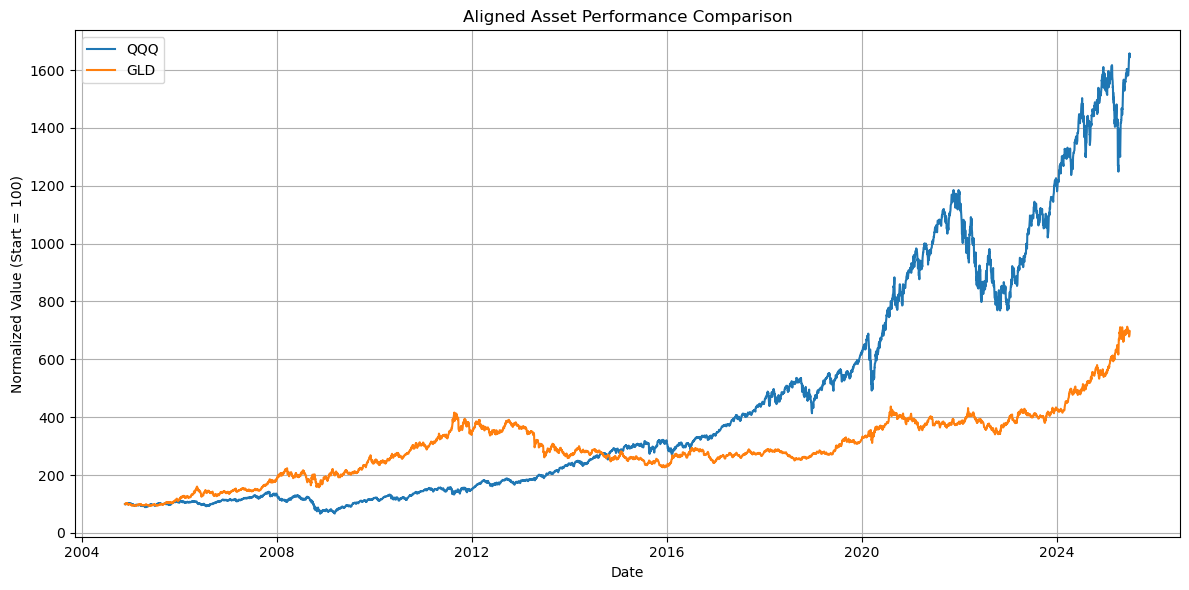

📊 Stats for QQQ
----------------------------------------
Start Price:           33.28
End Price:             550.8
Return Ratio:          16.5507
Total Return (%):      1555.07%
Sharpe Ratio:          0.7363
Max Drop (%):          -53.4%
Shock Rate (%):        0.94%
Weekly Shock (%):      0.94%
Avg Drop Rate (%):     -0.99%
Max Loss Duration:     781 days
Avg Loss Duration:     18.03 days
Best Leverage Ratio:   N/A
📊 Stats for GLD
----------------------------------------
Start Price:           44.38
End Price:             309.25
Return Ratio:          6.9682
Total Return (%):      596.82%
Sharpe Ratio:          0.6244
Max Drop (%):          -45.56%
Shock Rate (%):        0.79%
Weekly Shock (%):      0.79%
Avg Drop Rate (%):     -0.8%
Max Loss Duration:     2247 days
Avg Loss Duration:     46.6 days
Best Leverage Ratio:   N/A


In [37]:
viewer = MultiAssetPerformanceViewer([asset_qqq, asset_gld])
viewer.plot()

compute_display([asset_qqq, asset_gld])




In [38]:
class LeverageSimulator:
    def __init__(self, asset: AssetData, leverage: float = 1.0, label: str = "LeveragedAsset"):
        self.asset = asset
        self.df = asset.df.copy()
        self.price_col = asset.price_col
        self.date_col = asset.date_col
        self.leverage = leverage
        self.label = label

        if not pd.api.types.is_datetime64_any_dtype(self.df[self.date_col]):
            self.df[self.date_col] = pd.to_datetime(self.df[self.date_col])

        self.df = self.df.sort_values(self.date_col)

    def simulate(self, start_value: float = 100.0) -> pd.DataFrame:
        price_series = self.df[self.price_col].dropna()

        # Calculate daily % change and apply leverage
        returns = price_series.pct_change().fillna(0)
        leveraged_returns = returns * self.leverage

        # Simulate portfolio growth
        simulated_value = (1 + leveraged_returns).cumprod() * start_value

        result = pd.DataFrame({
            self.date_col: self.df[self.date_col].iloc[-len(simulated_value):].values,
            f"{self.label}_value": simulated_value.values,
            f"{self.label}_price": price_series.values
        })

        return result


In [39]:
# === Simulate Leveraged GLD and QQQ using your LeverageSimulator class ===

# Step 1: Simulate 2x leveraged QQQ
qqq2_simulator = LeverageSimulator(asset_qqq, leverage=2.0, label="QQQx2")
df_qqq2 = qqq2_simulator.simulate()

asset_qqq2 = AssetData(
    name="QQQx2",
    df=df_qqq2.rename(columns={
        f"{qqq2_simulator.date_col}": "date",
        f"{qqq2_simulator.label}_value": "adjcp"  # Simulated value acts as synthetic adjusted close
    })[["date", "adjcp"]],
    price_col="adjcp",
    date_col="date"
)

# Step 2: Simulate 2x leveraged GLD
gld2_simulator = LeverageSimulator(asset_gld, leverage=2.0, label="GLDx2")
df_gld2 = gld2_simulator.simulate()

asset_gld2 = AssetData(
    name="GLDx2",
    df=df_gld2.rename(columns={
        f"{gld2_simulator.date_col}": "date",
        f"{gld2_simulator.label}_value": "adjcp"
    })[["date", "adjcp"]],
    price_col="adjcp",
    date_col="date"
)

qqq3_simulator = LeverageSimulator(asset_qqq, leverage=3.0, label="QQQx2")
df_qqq3 = qqq3_simulator.simulate()

asset_qqq3 = AssetData(
    name="QQQx3",
    df=df_qqq3.rename(columns={
        f"{qqq3_simulator.date_col}": "date",
        f"{qqq3_simulator.label}_value": "adjcp"  # Simulated value acts as synthetic adjusted close
    })[["date", "adjcp"]],
    price_col="adjcp",
    date_col="date"
)

# Step 2: Simulate 2x leveraged GLD
gld3_simulator = LeverageSimulator(asset_gld, leverage=3.0, label="GLDx2")
df_gld3 = gld3_simulator.simulate()

asset_gld3 = AssetData(
    name="GLDx3",
    df=df_gld3.rename(columns={
        f"{gld3_simulator.date_col}": "date",
        f"{gld3_simulator.label}_value": "adjcp"
    })[["date", "adjcp"]],
    price_col="adjcp",
    date_col="date"
)






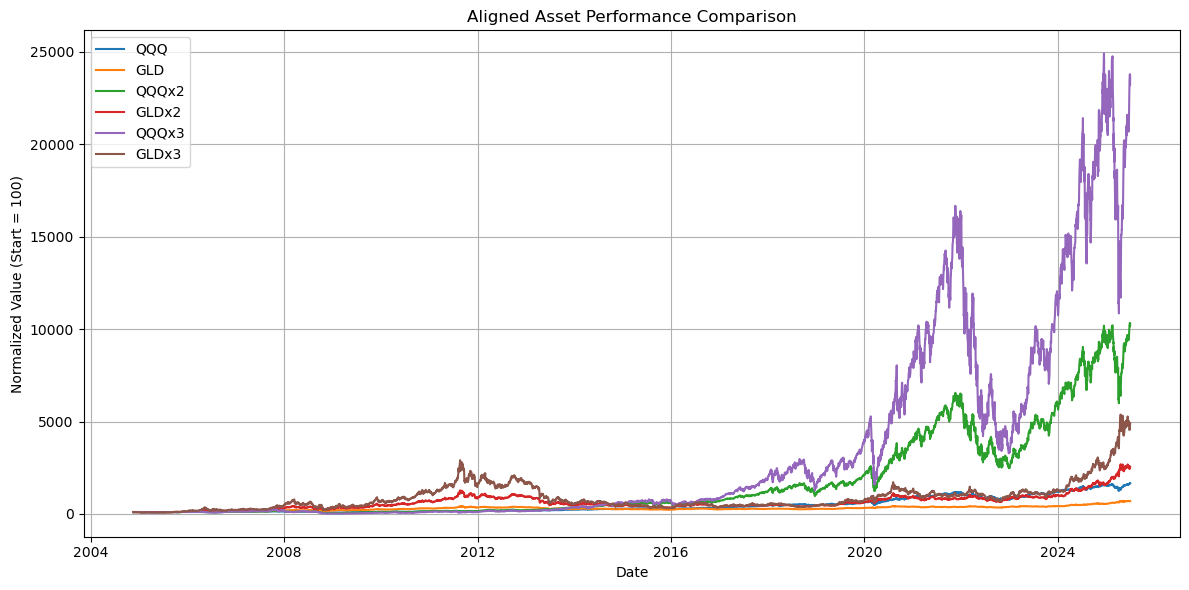

📊 Stats for QQQ
----------------------------------------
Start Price:           33.28
End Price:             550.8
Return Ratio:          16.5507
Total Return (%):      1555.07%
Sharpe Ratio:          0.7363
Max Drop (%):          -53.4%
Shock Rate (%):        0.94%
Weekly Shock (%):      0.94%
Avg Drop Rate (%):     -0.99%
Max Loss Duration:     781 days
Avg Loss Duration:     18.03 days
Best Leverage Ratio:   N/A
📊 Stats for GLD
----------------------------------------
Start Price:           44.38
End Price:             309.25
Return Ratio:          6.9682
Total Return (%):      596.82%
Sharpe Ratio:          0.6244
Max Drop (%):          -45.56%
Shock Rate (%):        0.79%
Weekly Shock (%):      0.79%
Avg Drop Rate (%):     -0.8%
Max Loss Duration:     2247 days
Avg Loss Duration:     46.6 days
Best Leverage Ratio:   N/A
📊 Stats for QQQx2
----------------------------------------
Start Price:           31.36
End Price:             3228.11
Return Ratio:          102.9292
Total Return

In [40]:


# Step 3: View all 4 assets
viewer = MultiAssetPerformanceViewer([asset_qqq, asset_gld, asset_qqq2, asset_gld2,asset_qqq3,asset_gld3])
viewer.plot()


compute_display([asset_qqq, asset_gld,asset_qqq2,asset_gld2,asset_qqq3,asset_gld3])





In [41]:



@dataclass
class TradeRecord:
    asset: AssetData                  # Original asset info
    share_series: pd.Series          # Index = datetime, Value = holding amount
    
    
def build_portfolio_asset(
    name: str,
    records: list[TradeRecord],
    date_index: pd.DatetimeIndex,
    cash_rate: float = 0.0
) -> AssetData:
    """
    Merges multiple TradeRecords into a single portfolio AssetData using a predefined date index.
    Optionally apply a cash_rate (e.g., interest for uninvested capital).
    """
    if date_index is None or len(date_index) == 0:
        print(f"❌ Provided date index is empty for portfolio '{name}'")
        return AssetData(name=name, df=pd.DataFrame(), price_col="adjcp", date_col="date")

    df_portfolio = pd.DataFrame(index=date_index)
    df_portfolio.index.name = "date"
    total_value = pd.Series(0.0, index=date_index)

    for rec in records:
        if rec.share_series is None or rec.share_series.dropna().empty:
            print(f"⚠️ [{rec.asset.name}] Share series is missing or empty.")
            continue

        df = rec.asset.df.copy()
        if df.empty or rec.asset.price_col not in df.columns:
            print(f"⚠️ [{rec.asset.name}] DataFrame or price column missing.")
            continue

        df[rec.asset.date_col] = pd.to_datetime(df[rec.asset.date_col])
        df = df.set_index(df[rec.asset.date_col])
        price = df[rec.asset.price_col].reindex(date_index).ffill()

        shares = rec.share_series.reindex(date_index).ffill().fillna(0)

        if price.isnull().all():
            print(f"⚠️ [{rec.asset.name}] All prices are NaN after reindexing.")
            continue
        if price.iloc[0] == 0:
            print(f"⚠️ [{rec.asset.name}] First price is 0. Skipping contribution.")
            continue

        total_value += price * shares

    # Step 3: Apply optional constant cash growth
    if cash_rate > 0:
        days = (date_index - date_index[0]).days
        cash_growth = 100 * ((1 + cash_rate) ** (days / 365.0) - 1)
        total_value += cash_growth

    # Step 4: Output final result
    df_result = pd.DataFrame({
        "date": date_index,
        "adjcp": total_value
    }).reset_index(drop=True)

    if (df_result["adjcp"] == 0).all():
        print(f"❌ Portfolio '{name}' has all-zero values. Check inputs.")
    elif df_result["adjcp"].dropna().shape[0] < 10:
        print(f"⚠️ Portfolio '{name}' has very few non-zero rows. Might be invalid.")
    else:
        print(f"✅ Portfolio '{name}' built with {len(df_result)} rows.")

    asset = AssetData(name=name, df=df_result, price_col="adjcp", date_col="date")
    compute_asset_stats(asset)
    return asset



In [42]:




# === Step 1: Create business-day-aligned date range ===
common_dates = pd.date_range(start=START_DATE, end=END_DATE, freq="B")
print("✅ Common date range:", common_dates[0], "to", common_dates[-1])
print("✅ Total business days:", len(common_dates))


# === Step 2: Safe reindexing function for each asset ===
def get_price_series(asset: AssetData, common_dates: pd.DatetimeIndex) -> pd.Series:
    df = asset.df.copy()

    # Ensure datetime format
    if not pd.api.types.is_datetime64_any_dtype(df[asset.date_col]):
        df[asset.date_col] = pd.to_datetime(df[asset.date_col])

    df = df.set_index(asset.date_col)
    aligned = df.reindex(common_dates)

    # Forward fill
    aligned_ffill = aligned.fillna(method="ffill")

    if aligned_ffill[asset.price_col].isna().all():
        print(f"⚠️ Warning: {asset.name} price column is all NaN after alignment.")
    elif (aligned_ffill[asset.price_col] == 0).all():
        print(f"⚠️ Warning: {asset.name} price series is all zeros after reindex.")
    else:
        print(f"✅ {asset.name} price series aligned. Head:\n", aligned_ffill[asset.price_col].head())

        # Optional: Keep only dates where the asset had real prices (non-NaN and non-zero)
    cleaned = aligned_ffill[asset.price_col]
    cleaned = cleaned[cleaned.notna() & (cleaned != 0)]

    return cleaned


# === Step 4: Define initial capital allocation and share series ===
initial_value = 100

# Define custom portion allocations (e.g., 60% QQQ, 40% GLD)
alloc = {
    "QQQ": 0.6,
    "GLD": 0.4,
    "QQQ3": 0.5,
    "GLD3": 0.5
}

# Extract first prices directly
qqq_price0 = asset_qqq.df[asset_qqq.price_col].iloc[0]
gld_price0 = asset_gld.df[asset_gld.price_col].iloc[0]
qqq3_price0 = asset_qqq3.df[asset_qqq3.price_col].iloc[0]
gld3_price0 = asset_gld3.df[asset_gld3.price_col].iloc[0]

# Compute constant shares using allocation ratio
qqq_shares = (initial_value * alloc["QQQ"]) / qqq_price0
gld_shares = (initial_value * alloc["GLD"]) / gld_price0
qqq3_shares = (initial_value * alloc["QQQ3"]) / qqq3_price0
gld3_shares = (initial_value * alloc["GLD3"]) / gld3_price0

# Create constant share series over the common timeline
qqq_share_series = pd.Series(qqq_shares, index=common_dates)
gld_share_series = pd.Series(gld_shares, index=common_dates)
qqq3_share_series = pd.Series(qqq3_shares, index=common_dates)
gld3_share_series = pd.Series(gld3_shares, index=common_dates)

# === Step 5: Create TradeRecord wrappers ===
record_qqq = TradeRecord(asset=asset_qqq, share_series=qqq_share_series)
record_gld = TradeRecord(asset=asset_gld, share_series=gld_share_series)
record_qqq3 = TradeRecord(asset=asset_qqq3, share_series=qqq3_share_series)
record_gld3 = TradeRecord(asset=asset_gld3, share_series=gld3_share_series)

# === Step 6: Build portfolios with common date index ===
asset_combo_qqq_gld = build_portfolio_asset("QQQ+GLD", [record_qqq, record_gld], date_index=common_dates)
asset_combo_qqq3_gld3 = build_portfolio_asset("QQQ3+GLD3", [record_qqq3, record_gld3], date_index=common_dates)



✅ Common date range: 2001-01-01 00:00:00 to 2025-07-03 00:00:00
✅ Total business days: 6394
✅ Portfolio 'QQQ+GLD' built with 6394 rows.
✅ Portfolio 'QQQ3+GLD3' built with 6394 rows.


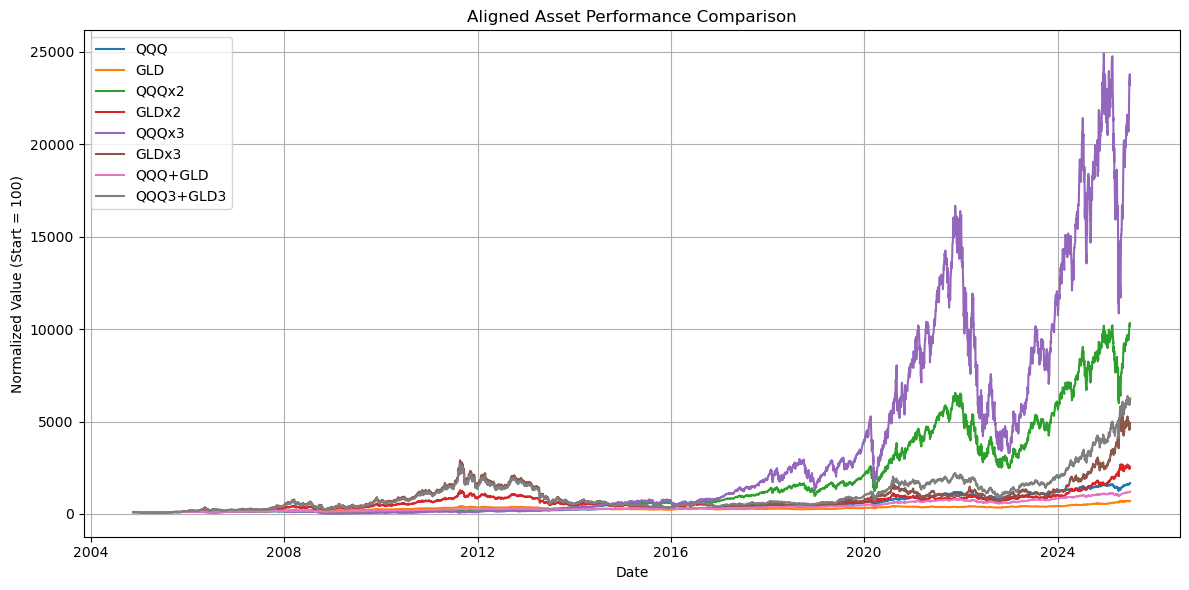

📊 Stats for QQQ
----------------------------------------
Start Price:           33.28
End Price:             550.8
Return Ratio:          16.5507
Total Return (%):      1555.07%
Sharpe Ratio:          0.7363
Max Drop (%):          -53.4%
Shock Rate (%):        0.94%
Weekly Shock (%):      0.94%
Avg Drop Rate (%):     -0.99%
Max Loss Duration:     781 days
Avg Loss Duration:     18.03 days
Best Leverage Ratio:   N/A
📊 Stats for GLD
----------------------------------------
Start Price:           44.38
End Price:             309.25
Return Ratio:          6.9682
Total Return (%):      596.82%
Sharpe Ratio:          0.6244
Max Drop (%):          -45.56%
Shock Rate (%):        0.79%
Weekly Shock (%):      0.79%
Avg Drop Rate (%):     -0.8%
Max Loss Duration:     2247 days
Avg Loss Duration:     46.6 days
Best Leverage Ratio:   N/A
📊 Stats for QQQx2
----------------------------------------
Start Price:           31.36
End Price:             3228.11
Return Ratio:          102.9292
Total Return

In [43]:
viewer = MultiAssetPerformanceViewer([asset_qqq, asset_gld,asset_qqq2,asset_gld2,asset_qqq3,asset_gld3,asset_combo_qqq_gld,asset_combo_qqq3_gld3])
viewer.plot()


compute_display([asset_qqq, asset_gld,asset_qqq2,asset_gld2,asset_qqq3,asset_gld3,asset_combo_qqq_gld,asset_combo_qqq3_gld3])

In [44]:
from dataclasses import dataclass
from typing import List
import pandas as pd
import numpy as np
from datetime import datetime

@dataclass
class MACrossSignal:
    date: datetime
    ratio: float
    ma_short: float
    ma_long: float
    cross: str  # "up", "down", "none"

class MACrossDetector:
    def __init__(self, asset1: AssetData, asset2: AssetData, ma_short_window: int = 5, ma_long_window: int = 10):
        self.asset1 = asset1
        self.asset2 = asset2
        self.ma_short_window = ma_short_window
        self.ma_long_window = ma_long_window
        self.signals: List[MACrossSignal] = []

    def compute(self) -> List[MACrossSignal]:
        df1 = self.asset1.df.copy()
        df2 = self.asset2.df.copy()

        df1[self.asset1.date_col] = pd.to_datetime(df1[self.asset1.date_col])
        df2[self.asset2.date_col] = pd.to_datetime(df2[self.asset2.date_col])

        df1 = df1.set_index(self.asset1.date_col)
        df2 = df2.set_index(self.asset2.date_col)

        ratio_df = pd.DataFrame(index=df1.index.union(df2.index).sort_values())
        ratio_df['price1'] = df1[self.asset1.price_col]
        ratio_df['price2'] = df2[self.asset2.price_col]
        ratio_df = ratio_df.ffill()
        ratio_df['ratio'] = ratio_df['price1'] / ratio_df['price2']

        ratio_df['ma_short'] = ratio_df['ratio'].rolling(self.ma_short_window).mean()
        ratio_df['ma_long'] = ratio_df['ratio'].rolling(self.ma_long_window).mean()

        prev_short = prev_long = None
        prev_date = None

        for date, row in ratio_df.iterrows():
            if pd.isna(row['ma_short']) or pd.isna(row['ma_long']):
                prev_date = date
                continue

            cross = "none"
            if prev_short is not None and prev_long is not None:
                if prev_short < prev_long and row['ma_short'] > row['ma_long']:
                    cross = "up"
                elif prev_short > prev_long and row['ma_short'] < row['ma_long']:
                    cross = "down"

            self.signals.append(MACrossSignal(
                date=prev_date if cross != "none" else date,
                ratio=row['ratio'],
                ma_short=row['ma_short'],
                ma_long=row['ma_long'],
                cross=cross
            ))

            prev_short = row['ma_short']
            prev_long = row['ma_long']
            prev_date = date


        return self.signals


In [45]:
detector = MACrossDetector(asset1=asset_qqq, asset2=asset_gld)
qqq_gld_signals = detector.compute()

for sig in qqq_gld_signals[-10:]:
    print(f"{sig.date.date()} | ratio={sig.ratio:.4f} | short={sig.ma_short:.4f} | long={sig.ma_long:.4f} | cross={sig.cross}")


2025-06-18 | ratio=1.7031 | short=1.6961 | long=1.7103 | cross=none
2025-06-20 | ratio=1.6968 | short=1.6940 | long=1.7105 | cross=none
2025-06-23 | ratio=1.7090 | short=1.7030 | long=1.7080 | cross=none
2025-06-23 | ratio=1.7629 | short=1.7132 | long=1.7114 | cross=up
2025-06-25 | ratio=1.7620 | short=1.7268 | long=1.7136 | cross=none
2025-06-26 | ratio=1.7805 | short=1.7423 | long=1.7192 | cross=none
2025-06-27 | ratio=1.8196 | short=1.7668 | long=1.7304 | cross=none
2025-06-30 | ratio=1.8097 | short=1.7869 | long=1.7450 | cross=none
2025-07-01 | ratio=1.7785 | short=1.7901 | long=1.7516 | cross=none
2025-07-02 | ratio=1.7811 | short=1.7939 | long=1.7603 | cross=none


In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import List, Optional
import pandas as pd

class MACrossPlotter:
    def __init__(self, signal_list: List[MACrossSignal]):
        self.original_signals = signal_list
        self.df = self._to_dataframe(signal_list)

    def _to_dataframe(self, signals: List[MACrossSignal]) -> pd.DataFrame:
        return pd.DataFrame([{
            'Date': signal.date,
            'MA5': signal.ma_short,
            'MA10': signal.ma_long,
            'Cross': signal.cross
        } for signal in signals]).sort_values("Date")

    def plot(self, start_date: Optional[str] = None, end_date: Optional[str] = None):
        df = self.df.copy()

        # Convert date to datetime and filter range
        df['Date'] = pd.to_datetime(df['Date'])
        if start_date:
            df = df[df['Date'] >= pd.to_datetime(start_date)]
        if end_date:
            df = df[df['Date'] <= pd.to_datetime(end_date)]

        if df.empty:
            print("⚠️ No data to plot in the selected date range.")
            return

        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'], df['MA5'], label='MA5 (Asset1 / Asset2)', linewidth=1.5)
        plt.plot(df['Date'], df['MA10'], label='MA10 (Asset1 / Asset2)', linewidth=1.5)

        # Highlight cross points
        cross_df = df[df['Cross'].isin(['up', 'down'])]
        for _, row in cross_df.iterrows():
            color = 'green' if row['Cross'] == 'up' else 'red'
            marker = '^' if row['Cross'] == 'up' else 'v'
            plt.scatter(row['Date'], row['MA5'], color=color, marker=marker)
            plt.text(row['Date'], row['MA5'], '↑' if row['Cross'] == 'up' else '↓',
                     color=color, fontsize=10, ha='center')

        plt.title("📈 MA Cross Points (Asset1 / Asset2)")
        plt.xlabel("Date")
        plt.ylabel("MA Ratio")
        plt.legend()
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_50696\1844695452.py:53: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\anaconda3\envs\quant_trade_playground\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


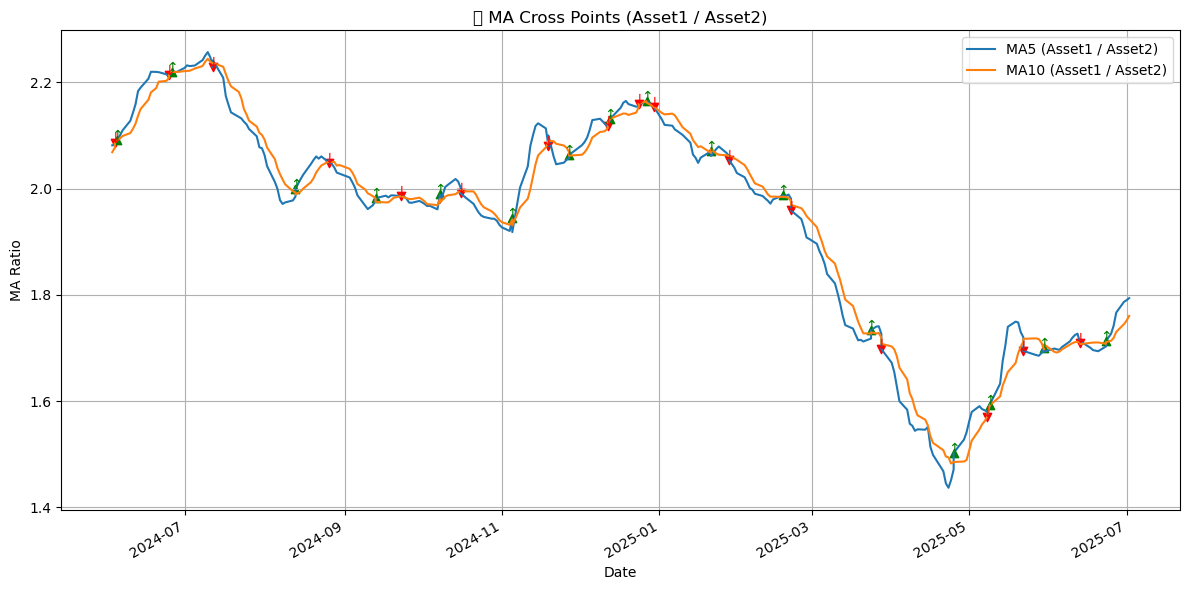

In [47]:
plotter = MACrossPlotter(qqq_gld_signals )
plotter.plot(start_date="2024-06-01", end_date=END_DATE)



In [48]:
from dataclasses import dataclass
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Union
from datetime import datetime
import copy


@dataclass
class TradeSignal:
    date: pd.Timestamp
    action: str  # "BUY_ASSET1" or "BUY_ASSET2"
    share: float  # proportion of capital reallocated



class DualAssetGridStatus:
    def __init__(self, asset1: AssetData, asset2: AssetData,
                 init_capital=100000,
                 init_percent_asset1=0.5,
                 init_percent_asset2=0.5,
                 percent_low_limit1=0.05,
                 percent_low_limit2=0.05):
        self.asset1 = asset1
        self.asset2 = asset2
        self.percent_low_limit1 = percent_low_limit1
        self.percent_low_limit2 = percent_low_limit2

        self.asset1_value = init_capital * init_percent_asset1
        self.asset2_value = init_capital * init_percent_asset2

        price1 = asset1.df.iloc[0][asset1.price_col]
        price2 = asset2.df.iloc[0][asset2.price_col]

        self.asset1_share = self.asset1_value / price1
        self.asset2_share = self.asset2_value / price2

    def trade(self, action: str, price1: float, price2: float, unit: float) -> bool:
        total_value = self.total_value(price1, price2)

        if action == "BUY_ASSET1":
            if self.asset2_share * price2 < unit * price2:
                return False
            if self.asset2_share * price2 < self.percent_low_limit2 * total_value:
                return False
            value = unit * price2
            buy_share = value / price1
            self.asset2_share -= unit
            self.asset1_share += buy_share
            return True

        elif action == "BUY_ASSET2":
            if self.asset1_share * price1 < unit * price1:
                return False
            if self.asset1_share * price1 < self.percent_low_limit1 * total_value:
                return False
            value = unit * price1
            buy_share = value / price2
            self.asset1_share -= unit
            self.asset2_share += buy_share
            return True

        return False

    def total_value(self, price1: float, price2: float) -> float:
        return self.asset1_share * price1 + self.asset2_share * price2

    def clone(self):
        cloned = DualAssetGridStatus(
            asset1=self.asset1,
            asset2=self.asset2,
            init_capital=1,  # Placeholder to bypass __init__ logic
        )
        cloned.percent_low_limit1 = self.percent_low_limit1
        cloned.percent_low_limit2 = self.percent_low_limit2
        cloned.asset1_share = self.asset1_share
        cloned.asset2_share = self.asset2_share
        return cloned



class BooleanGridStrategy:
    def __init__(self,
                 status: DualAssetGridStatus,
                 window=20,
                 std_multiplier=1.0,
                 grid_dense=4,
                 transaction_unit=0.01):
        self.status = status
        self.asset1 = status.asset1
        self.asset2 = status.asset2

        self.window = window
        self.std_multiplier = std_multiplier
        self.grid_dense = grid_dense
        self.transaction_unit = transaction_unit

        self.signals = []
        self.last_action = None
        self.last_grid_level = None

    def run(self):
    # Merge prices on date to ensure alignment
        df = pd.merge(
            self.asset1.df[[self.asset1.date_col, self.asset1.price_col]],
            self.asset2.df[[self.asset2.date_col, self.asset2.price_col]],
            left_on=self.asset1.date_col,
            right_on=self.asset2.date_col,
            how='inner'
        )

        df.columns = ['date', 'price1', 'price2']
        df.dropna(subset=['price1', 'price2'], inplace=True)
        df['ratio'] = df['price1'] / df['price2']
        df['mean'] = df['ratio'].rolling(window=self.window).mean()
        df['std'] = df['ratio'].rolling(window=self.window).std()
        df['upper'] = df['mean'] + self.std_multiplier * df['std']
        df['lower'] = df['mean'] - self.std_multiplier * df['std']

        self.df = df.reset_index(drop=True)
        print(f"📅 Available ratio date range: {df['date'].min()} to {df['date'].max()}")
        print(f"🧪 Last 5 rows after band calculation:\n{df.tail()}")

        for i in range(self.window, len(df)):
            row = df.iloc[i]
            date = row['date']
            price1 = row['price1']
            price2 = row['price2']
            ratio = row['ratio']
            upper = row['upper']
            lower = row['lower']

            if pd.isna(upper) or pd.isna(lower):
                continue

            grid_unit = (upper - lower) / self.grid_dense
            current_grid_level = int((ratio - lower) / grid_unit)

            if self.last_grid_level is None:
                self.last_grid_level = current_grid_level
                continue

            grid_movement = current_grid_level - self.last_grid_level
            action = None

            if grid_movement >= 1:
                action = "BUY_ASSET2"
            elif grid_movement <= -1:
                action = "BUY_ASSET1"

            if action:
                total_value = self.status.total_value(price1, price2)

                # Adjust value_to_trade based on long-term valuation
                if action == "BUY_ASSET2":
                    value_to_trade = total_value * self.transaction_unit *2 
                    share = value_to_trade / price1
                else:  # BUY_ASSET1
                    value_to_trade = total_value * self.transaction_unit 
                    share = value_to_trade / price2

                success = self.status.trade(action, price1, price2, share)
                if success:
                    signal = TradeSignal(date=date, action=action, share=share)
                    self.signals.append(signal)
                    self.last_action = action
                    self.last_grid_level = current_grid_level
                    print(f"📈 {date.date()} | {action} | ratio={ratio:.4f} | value={value_to_trade:.2f} | share={share:.4f}")

        print(f"✅ Completed backtest with {len(self.signals)} trade signals.")
        if self.signals:
            print("🔁 Last 5 signals:")
            for sig in self.signals[-5:]:
                print(sig)



    def suggest_actions_for_next_day(self):
        # Merge and prepare price dataframe
        df = pd.merge(
            self.asset1.df[[self.asset1.date_col, self.asset1.price_col]],
            self.asset2.df[[self.asset2.date_col, self.asset2.price_col]],
            left_on=self.asset1.date_col,
            right_on=self.asset2.date_col,
            how='inner'
        )
        df.columns = ['date', 'price1', 'price2']
        df.dropna(subset=['price1', 'price2'], inplace=True)
        df['ratio'] = df['price1'] / df['price2']
        df['mean'] = df['ratio'].rolling(window=self.window).mean()
        df['std'] = df['ratio'].rolling(window=self.window).std()
        df['upper'] = df['mean'] + self.std_multiplier * df['std']
        df['lower'] = df['mean'] - self.std_multiplier * df['std']
        df = df.reset_index(drop=True)

        # Use last valid row for prediction
        last_valid = df.dropna().iloc[-1]
        date = last_valid['date']
        price1 = last_valid['price1']
        price2 = last_valid['price2']
        ratio = last_valid['ratio']
        upper = last_valid['upper']
        lower = last_valid['lower']

        grid_unit = (upper - lower) / self.grid_dense
        current_grid_level = int((ratio - lower) / grid_unit)
        total_value = self.status.total_value(price1, price2)

        print(f"📊 Latest ratio info on {date.date()}:")
        print(f"   - Ratio: {ratio:.4f}")
        print(f"   - Grid band: [{lower:.4f}, {upper:.4f}]")
        print(f"   - Grid unit size: {grid_unit:.4f}")
        print(f"   - Current grid level: {current_grid_level}")
        print(f"🔮 Simulating potential actions for tomorrow...")

        suggestions = []
        for delta in [-2, -1, 0, 1, 2]:
            test_level = current_grid_level + delta
            test_ratio = lower + test_level * grid_unit

            if test_level > current_grid_level:
                action = "BUY_ASSET2"
                value_to_trade = total_value * self.transaction_unit * 2
                share = value_to_trade / price2
            elif test_level < current_grid_level:
                action = "BUY_ASSET1"
                value_to_trade = total_value * self.transaction_unit
                share = value_to_trade / price1
            else:
                action = "HOLD"
                value_to_trade = 0
                share = 0

            suggestions.append({
                "grid_level": test_level,
                "simulated_ratio": round(test_ratio, 4),
                "action": action,
                "suggested_share": round(share, 4),
                "trade_value": round(value_to_trade, 2)
            })

        display(pd.DataFrame(suggestions))

    

    def build_asset_data(self, name: str) -> AssetData:
        if not hasattr(self, 'df'):
            raise ValueError("Run the strategy first.")

        df = self.df.copy()
        df['date'] = pd.to_datetime(df['date'])

        # Start from initial capital and status clone
        portfolio_values = []
        temp_status = self.status.clone()

        signal_idx = 0
        current_signal = self.signals[signal_idx] if self.signals else None

        for _, row in df.iterrows():
            date = row['date']
            price1 = row['price1']
            price2 = row['price2']

            # If there's a trade signal on this date, apply it
            while current_signal and current_signal.date == date:
                action = current_signal.action
                share = current_signal.share
                success = temp_status.trade(action, price1, price2, share)

                if success:
                    print(f"🪙 {date.date()} - Executed {action} for {share:.4f} shares at price1={price1:.2f}, price2={price2:.2f}")
                    print(f"   🔢 Status now: {temp_status.asset1_share:.4f} x {price1:.2f}, {temp_status.asset2_share:.4f} x {price2:.2f} → total = {temp_status.total_value(price1, price2):.2f}")
                else:
                    print(f"❌ {date.date()} - Failed to execute {action} at prices {price1:.2f}, {price2:.2f}")

                signal_idx += 1
                current_signal = self.signals[signal_idx] if signal_idx < len(self.signals) else None

            # Always compute and record portfolio value
            value = temp_status.total_value(price1, price2)
            portfolio_values.append(value)

        df['adjcp'] = portfolio_values
        df = df[['date', 'adjcp']].sort_values('date').reset_index(drop=True)

        return AssetData(
            name=name,
            df=df,
            price_col='adjcp',
            date_col='date',
            dates=df['date'],
            values=df['adjcp']
        )






    def plot(self, start_date=None, end_date=None):
        if self.df is None or not hasattr(self, "signals"):
            raise ValueError("Run the strategy before plotting.")

        df = self.df.copy()
        date_col = self.status.asset1.date_col
        df[date_col] = pd.to_datetime(df[date_col])

        # Convert start and end dates
        start_dt = pd.to_datetime(start_date) if start_date else df[date_col].min()
        end_dt = pd.to_datetime(end_date) if end_date else df[date_col].max()

        # Filter by date range
        df = df[(df[date_col] >= start_dt) & (df[date_col] <= end_dt)]

        # Drop NaNs in critical columns to ensure clean plotting
        df.dropna(subset=['ratio', 'mean', 'upper', 'lower'], inplace=True)

        if df.empty:
            print("⚠️ Warning: No usable data in the specified date range after cleaning.")
            return

        print(f"\n📅 Available plot date range: {df[date_col].min()} to {df[date_col].max()}")
        print("🔍 Last few rows of plot DataFrame:")
        print(df.tail(5)[[date_col, 'ratio', 'mean', 'upper', 'lower']])

        fig, ax = plt.subplots(figsize=(14, 6))

        # Plot ratio and bands
        ax.plot(df[date_col], df['ratio'], label='Ratio (Asset1 / Asset2)', color='black')
        ax.plot(df[date_col], df['mean'], label='Mean', linestyle='--', color='blue')
        ax.plot(df[date_col], df['upper'], label='Upper Band', linestyle='--', color='green')
        ax.plot(df[date_col], df['lower'], label='Lower Band', linestyle='--', color='red')

        # Plot intermediate grid levels
        for i in range(1, self.grid_dense):
            level = df['lower'] + i * (df['upper'] - df['lower']) / self.grid_dense
            ax.plot(df[date_col], level, linestyle=':', color='gray', linewidth=0.5)

        # Log and plot trade signals
        print("\n📈 Trade Signals:")
        if not self.signals:
            print("No signals generated.")
        else:
            plotted_labels = set()
            for signal in self.signals:
                signal_date = pd.to_datetime(signal.date)
                if not (start_dt <= signal_date <= end_dt):
                    continue

                # Find closest point in time
                closest = df.iloc[(df[date_col] - signal_date).abs().argsort()[:1]]
                if closest.empty:
                    continue

                y_val = closest['ratio'].values[0]
                color = 'green' if signal.action == 'BUY_ASSET1' else 'red'
                marker = '^' if signal.action == 'BUY_ASSET1' else 'v'
                label = signal.action if signal.action not in plotted_labels else ""

                ax.scatter(signal_date, y_val, color=color, marker=marker, s=100, label=label)
                plotted_labels.add(signal.action)

                # Log to console
                print(f" - {signal.date} | Action: {signal.action:<11} | Units: {signal.share}")

        ax.set_title('Boolean Grid Strategy - Asset1 / Asset2 Ratio')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price Ratio')
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        plt.show()



📅 Available ratio date range: 2004-11-18 00:00:00 to 2025-07-02 00:00:00
🧪 Last 5 rows after band calculation:
           date      price1      price2     ratio      mean       std  \
5182 2025-06-26  546.219971  306.779999  1.780494  1.719197  0.036833   
5183 2025-06-27  548.090027  301.220001  1.819567  1.730410  0.048176   
5184 2025-06-30  551.640015  304.829987  1.809665  1.744957  0.047923   
5185 2025-07-01  546.989990  307.549988  1.778540  1.751635  0.047433   
5186 2025-07-02  550.799988  309.250000  1.781083  1.760325  0.043539   

         upper     lower  
5182  1.792862  1.645532  
5183  1.826762  1.634058  
5184  1.840802  1.649111  
5185  1.846501  1.656770  
5186  1.847403  1.673246  
📈 2004-12-06 | BUY_ASSET2 | ratio=0.7551 | value=32266.73 | share=945.9703
📈 2004-12-07 | BUY_ASSET1 | ratio=0.7432 | value=16023.28 | share=355.2047
📈 2004-12-08 | BUY_ASSET2 | ratio=0.7662 | value=31791.58 | share=942.8095
📈 2004-12-15 | BUY_ASSET1 | ratio=0.7766 | value=15921.14 | sha

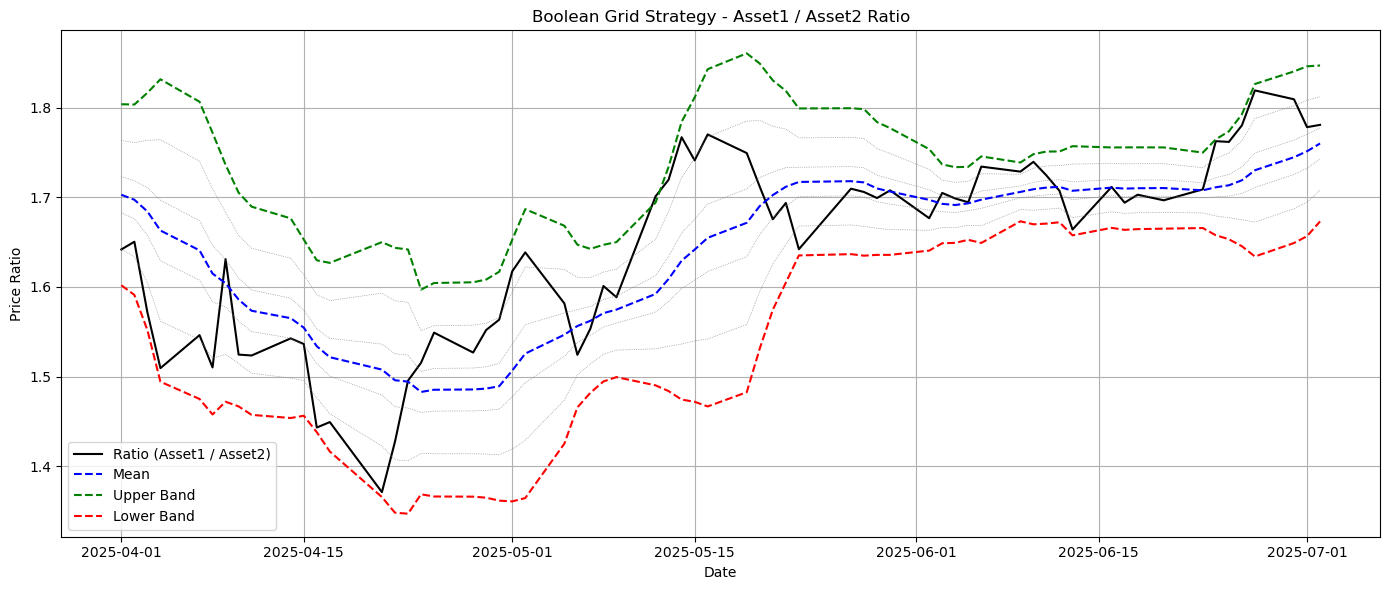

📅 Available ratio date range: 2004-11-18 00:00:00 to 2025-07-02 00:00:00
🧪 Last 5 rows after band calculation:
           date       price1       price2     ratio      mean       std  \
5182 2025-06-26  3175.202781  2518.807587  1.260598  1.175932  0.050532   
5183 2025-06-27  3196.944232  2427.507215  1.316966  1.191678  0.066769   
5184 2025-06-30  3238.357549  2485.692365  1.302799  1.211805  0.066910   
5185 2025-07-01  3183.762374  2530.052084  1.258378  1.221102  0.066203   
5186 2025-07-02  3228.114655  2558.022298  1.261957  1.233146  0.060854   

         upper     lower  
5182  1.276995  1.074869  
5183  1.325215  1.058141  
5184  1.345625  1.077985  
5185  1.353507  1.088697  
5186  1.354854  1.111439  
📈 2004-12-06 | BUY_ASSET2 | ratio=0.3180 | value=18815.80 | share=571.5923
📈 2004-12-07 | BUY_ASSET1 | ratio=0.3079 | value=9335.37 | share=90.4155
📈 2004-12-17 | BUY_ASSET1 | ratio=0.3255 | value=9129.81 | share=92.2536
📈 2004-12-22 | BUY_ASSET2 | ratio=0.3323 | value=18333.

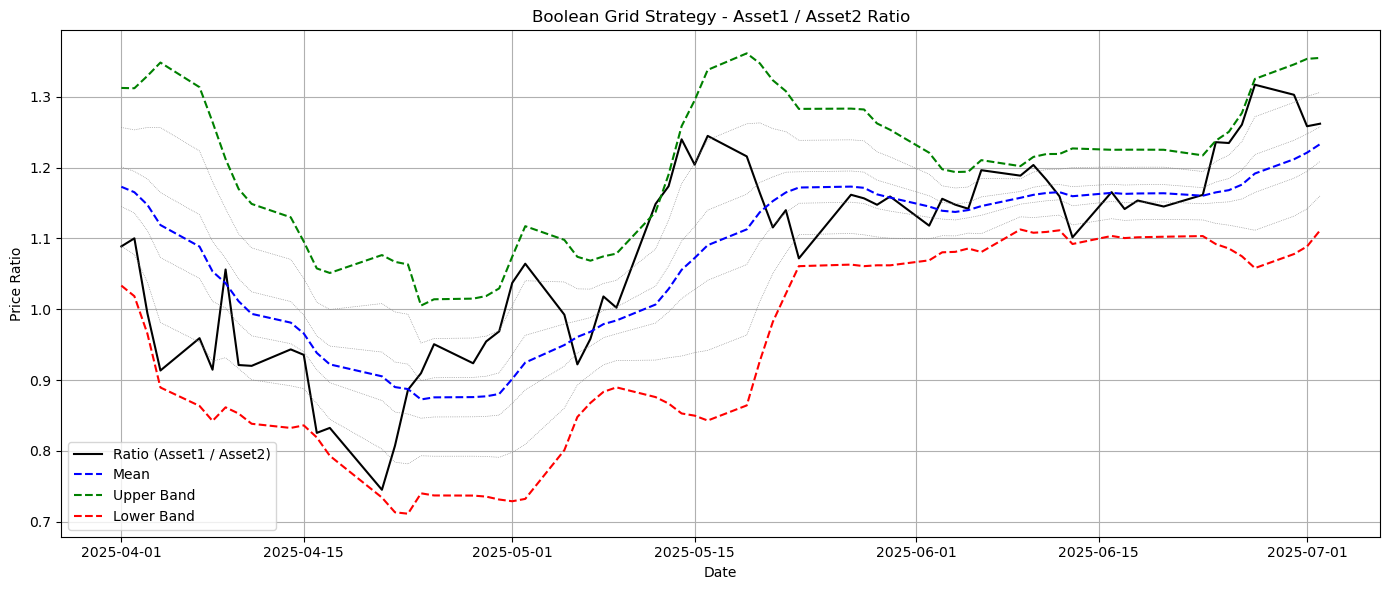

📅 Available ratio date range: 2004-11-18 00:00:00 to 2025-07-02 00:00:00
🧪 Last 5 rows after band calculation:
           date       price1       price2     ratio      mean       std  \
5182 2025-06-26  1783.335000  4804.123210  0.371209  0.334715  0.021638   
5183 2025-06-27  1801.651448  4542.917329  0.396585  0.341618  0.028895   
5184 2025-06-30  1836.659423  4706.251751  0.390259  0.350313  0.029166   
5185 2025-07-01  1790.213312  4832.233555  0.370473  0.354353  0.028847   
5186 2025-07-02  1827.621903  4912.365466  0.372045  0.359564  0.026554   

         upper     lower  
5182  0.377991  0.291439  
5183  0.399407  0.283828  
5184  0.408645  0.291982  
5185  0.412048  0.296658  
5186  0.412672  0.306457  
📈 2004-12-07 | BUY_ASSET1 | ratio=0.0750 | value=5450.48 | share=52.0025
📈 2004-12-08 | BUY_ASSET2 | ratio=0.0823 | value=10528.92 | share=1316.1819
📈 2004-12-15 | BUY_ASSET1 | ratio=0.0858 | value=5263.24 | share=54.3140
📈 2004-12-17 | BUY_ASSET1 | ratio=0.0817 | value=5266.

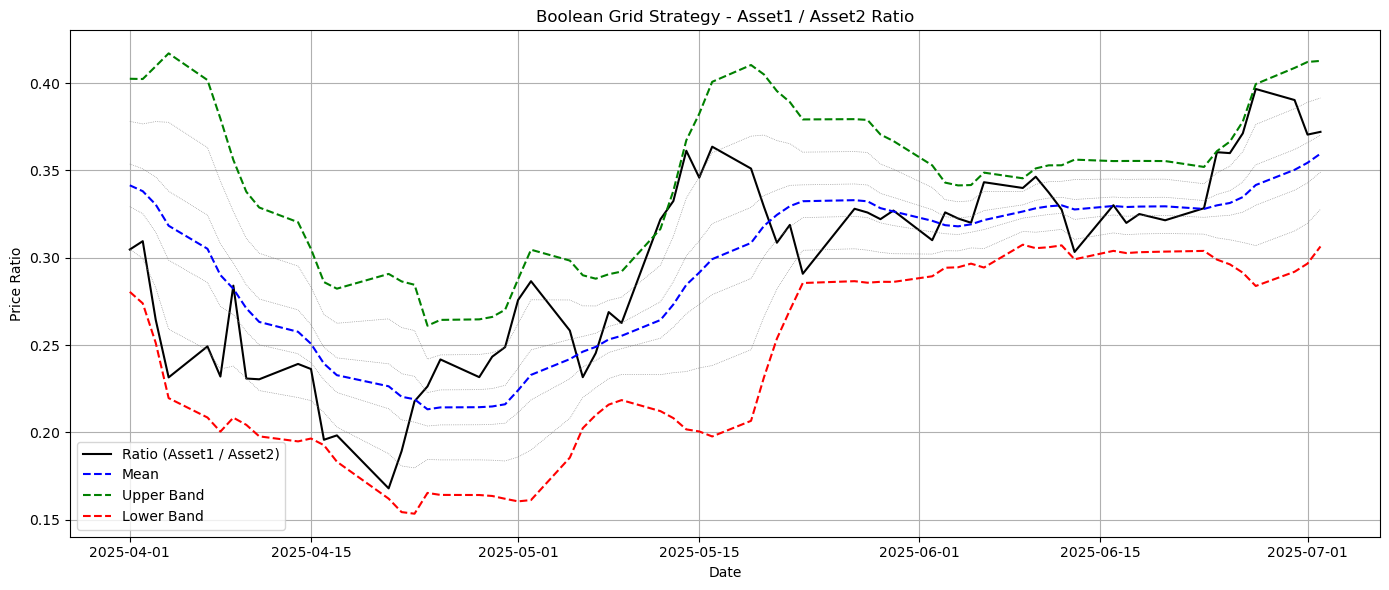

In [49]:
# Step 1: Create the DualAssetGridStatus object with 70:30 allocation
status_qqq_gld = DualAssetGridStatus(
    asset1=asset_qqq,
    asset2=asset_gld,
    percent_low_limit1=0.4,    # safety floor for asset1
    percent_low_limit2=0.05,    # safety floor for asset2
    init_capital=100000,
    init_percent_asset1=0.8, 
    init_percent_asset2=0.2
)

status_qqq2_gld2 = DualAssetGridStatus(
    asset1=asset_qqq2,
    asset2=asset_gld2,
    percent_low_limit1=0.3,    # safety floor for asset1
    percent_low_limit2=0.05,    # safety floor for asset2
    init_capital=100000,
    init_percent_asset1=0.8, 
    init_percent_asset2=0.2
)

status_qqq3_gld3 = DualAssetGridStatus(
    asset1=asset_qqq3,
    asset2=asset_gld3,
    percent_low_limit1=0.3,    # safety floor for asset1
    percent_low_limit2=0.1,    # safety floor for asset2
    init_capital=100000,
    init_percent_asset1=0.8, 
    init_percent_asset2=0.2
)

# Step 2: Initialize the strategy with that status
strategy_qqq_gld = BooleanGridStrategy(
    status=status_qqq_gld,
    window=10,
    std_multiplier=2,
    grid_dense=5,
    transaction_unit=0.2
)

strategy_qqq2_gld2 = BooleanGridStrategy(
    status=status_qqq2_gld2,
    window=10,
    std_multiplier=2,
    grid_dense=5,
    transaction_unit=0.2
)

strategy_qqq3_gld3 = BooleanGridStrategy(
    status=status_qqq3_gld3,
    window=10,
    std_multiplier=2,
    grid_dense=5,
    transaction_unit=0.2
)

# Step 3: Run strategy and plot results
strategy_qqq_gld.run()
strategy_qqq_gld.plot(start_date="2025-04-01", end_date=END_DATE)
strategy_qqq2_gld2.run()
strategy_qqq2_gld2.plot(start_date="2025-04-01", end_date=END_DATE)
strategy_qqq3_gld3.run()
strategy_qqq3_gld3.plot(start_date="2025-04-01", end_date=END_DATE)






❌ 2004-12-06 - Failed to execute BUY_ASSET2 at prices 34.11, 45.17
🪙 2004-12-07 - Executed BUY_ASSET1 for 355.2047 shares at price1=33.53, price2=45.11
   🔢 Status now: 882.8189 x 33.53, 1217.5222 x 45.11 → total = 84519.12
❌ 2004-12-08 - Failed to execute BUY_ASSET2 at prices 33.72, 44.01
🪙 2004-12-15 - Executed BUY_ASSET1 for 361.9263 shares at price1=34.16, price2=43.99
   🔢 Status now: 1348.8876 x 34.16, 855.5959 x 43.99 → total = 83716.33
🪙 2004-12-17 - Executed BUY_ASSET1 for 359.8261 shares at price1=33.75, price2=44.19
   🔢 Status now: 1819.9886 x 33.75, 495.7698 x 44.19 → total = 83336.76
🪙 2004-12-22 - Executed BUY_ASSET2 for 937.8026 shares at price1=33.97, price2=44.02
   🔢 Status now: 882.1860 x 33.97, 1219.5646 x 44.02 → total = 83657.13
🪙 2004-12-23 - Executed BUY_ASSET1 for 361.6278 shares at price1=34.00, price2=44.27
   🔢 Status now: 1353.0434 x 34.00, 857.9368 x 44.27 → total = 83984.66
🪙 2005-01-13 - Executed BUY_ASSET1 for 360.9961 shares at price1=32.56, price2=42

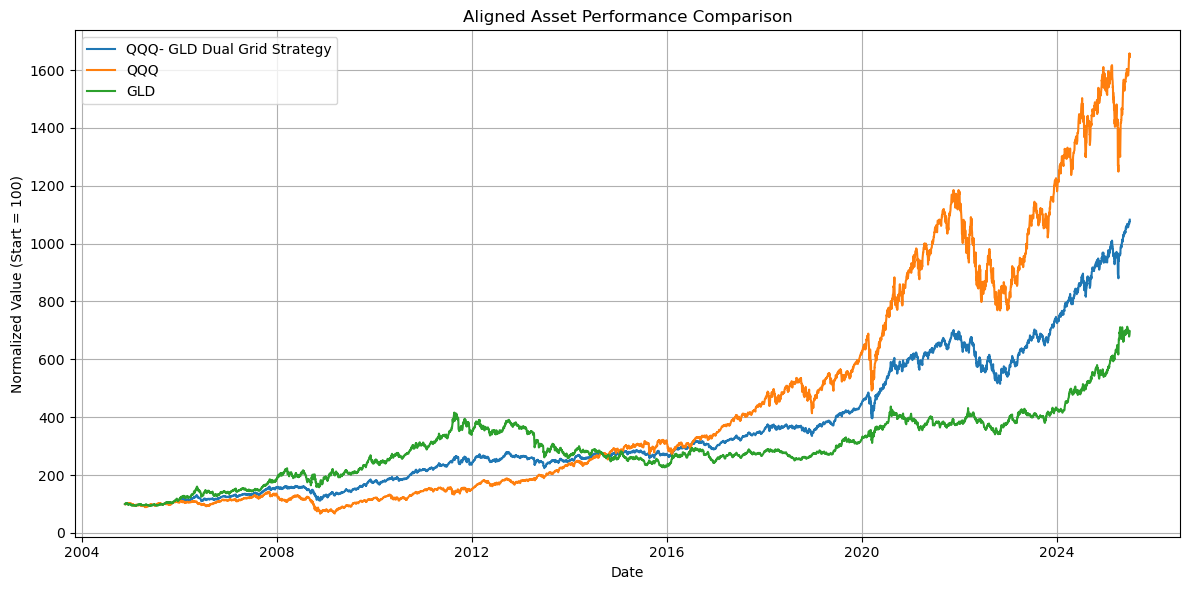

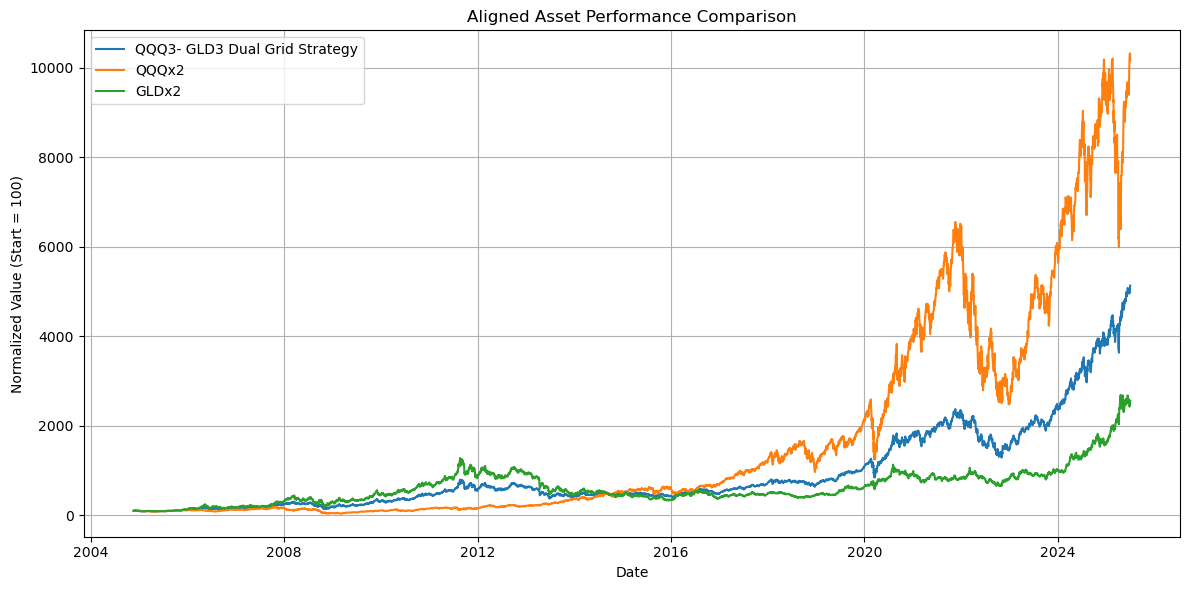

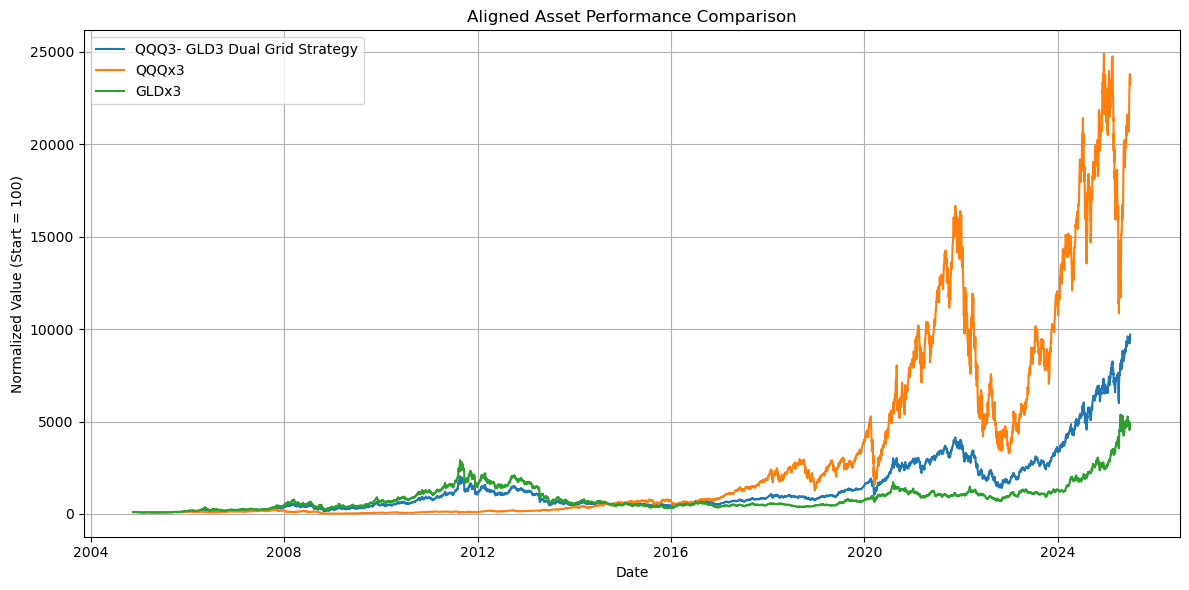

📊 Stats for QQQ- GLD Dual Grid Strategy
----------------------------------------
Start Price:           83271.58
End Price:             901516.6
Return Ratio:          10.8262
Total Return (%):      982.62%
Sharpe Ratio:          0.8728
Max Drop (%):          -31.45%
Shock Rate (%):        0.65%
Weekly Shock (%):      0.65%
Avg Drop Rate (%):     -0.67%
Max Loss Duration:     573 days
Avg Loss Duration:     18.93 days
Best Leverage Ratio:   N/A
📊 Stats for QQQ
----------------------------------------
Start Price:           33.28
End Price:             550.8
Return Ratio:          16.5507
Total Return (%):      1555.07%
Sharpe Ratio:          0.7363
Max Drop (%):          -53.4%
Shock Rate (%):        0.94%
Weekly Shock (%):      0.94%
Avg Drop Rate (%):     -0.99%
Max Loss Duration:     781 days
Avg Loss Duration:     18.03 days
Best Leverage Ratio:   N/A
📊 Stats for GLD
----------------------------------------
Start Price:           44.38
End Price:             309.25
Return Ratio:   

In [50]:
strategy_qqq_gld_asset = strategy_qqq_gld.build_asset_data("QQQ- GLD Dual Grid Strategy")
strategy_qqq2_gld2_asset = strategy_qqq2_gld2.build_asset_data("QQQ3- GLD3 Dual Grid Strategy")
strategy_qqq3_gld3_asset = strategy_qqq3_gld3.build_asset_data("QQQ3- GLD3 Dual Grid Strategy")

grid_compare_list_1X = [strategy_qqq_gld_asset,asset_qqq, asset_gld]
grid_compare_list_2X = [strategy_qqq2_gld2_asset,asset_qqq2, asset_gld2]
grid_compare_list_3X = [strategy_qqq3_gld3_asset,asset_qqq3, asset_gld3]
grid_compare_list_All = [strategy_qqq_gld_asset,asset_qqq, asset_gld, strategy_qqq2_gld2_asset,asset_qqq2, asset_gld2,strategy_qqq3_gld3_asset,asset_qqq3, asset_gld3]

viewer1 = MultiAssetPerformanceViewer(grid_compare_list_1X)
viewer2 = MultiAssetPerformanceViewer(grid_compare_list_2X )
viewer3 = MultiAssetPerformanceViewer(grid_compare_list_3X)

viewer1.plot()
viewer2.plot()
viewer3.plot()

compute_display(grid_compare_list_All)


In [51]:
def build_status_from_holdings(asset1: AssetData, asset2: AssetData,
                               price1: float, price2: float,
                               share1: float, share2: float,
                               percent_low_limit1=0.05, percent_low_limit2=0.05) -> DualAssetGridStatus:
    # Calculate total value
    value1 = share1 * price1
    value2 = share2 * price2
    total_value = value1 + value2

    # Back-calculate init capital % allocation
    init_percent_asset1 = value1 / total_value
    init_percent_asset2 = value2 / total_value

    # Create new status using these inferred values
    status = DualAssetGridStatus(
        asset1=asset1,
        asset2=asset2,
        init_capital=total_value,
        init_percent_asset1=init_percent_asset1,
        init_percent_asset2=init_percent_asset2,
        percent_low_limit1=percent_low_limit1,
        percent_low_limit2=percent_low_limit2,
    )

    # Overwrite the shares to match actual
    status.asset1_share = share1
    status.asset2_share = share2

    return status


In [52]:
 # Assume you fetched these from your broker/trading app:
price1 = 551  # e.g., QQQ
share1 = 10.0

price2 = 308  # e.g., GLD
share2 = 5

# Assume you already loaded asset1 and asset2 as AssetData objects
status_today = build_status_from_holdings(asset_qqq, asset_gld, price1, price2, share1, share2)

# Now you can use this `status` in any pair trading logic
print(f"📊 Total Portfolio Value = {status_today.total_value(price1, price2):.2f} USD")

strategy_today = BooleanGridStrategy(status=status_today)
strategy_today.suggest_actions_for_next_day()






📊 Total Portfolio Value = 7050.00 USD
📊 Latest ratio info on 2025-07-02:
   - Ratio: 1.7811
   - Grid band: [1.6925, 1.7777]
   - Grid unit size: 0.0213
   - Current grid level: 4
🔮 Simulating potential actions for tomorrow...


,grid_level,simulated_ratio,action,suggested_share,trade_value
0,2,1.7351,BUY_ASSET1,0.1281,70.54
1,3,1.7564,BUY_ASSET1,0.1281,70.54
2,4,1.7777,HOLD,0.0000,0.00
3,5,1.7991,BUY_ASSET2,0.4562,141.08
4,6,1.8204,BUY_ASSET2,0.4562,141.08
